In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from glob import iglob

In [2]:
data = pd.read_csv('data/raw/LoanStats3d_securev1.csv',skiprows=[0], low_memory=False)

In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,68407277,NaN,3600,3600,3600.0,36 months,13.99%,123.03,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,66310712,NaN,35000,35000,35000.0,60 months,14.85%,829.90,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68566886,NaN,29900,29900,29900.0,60 months,12.88%,678.49,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68495092,NaN,8650,8650,8650.0,36 months,19.89%,320.99,E,E3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68577849,NaN,18000,18000,18000.0,60 months,11.99%,400.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data['loan_status'].value_counts()

Current               240003
Fully Paid            123078
Charged Off            44186
Late (31-120 days)      7617
In Grace Period         4749
Late (16-30 days)       1451
Default                   11
Name: loan_status, dtype: int64

In [5]:
data = data[data['loan_status'].str.lower().isin(['fully paid', 'charged off'])]

In [6]:
data['application_type'].value_counts()

INDIVIDUAL    167111
JOINT            153
Name: application_type, dtype: int64

In [7]:
data = data[data['application_type'].str.lower()=='individual']

In [8]:
data.shape[0]

167111

In [9]:
(data['open_il_6m'][data['open_il_6m'].isnull() == False]).sum()

18740.0

In [10]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.999868
mths_since_last_delinq                 0.483762
mths_since_last_record                 0.807517
next_pymnt_d                           1.000000
mths_since_last_major_derog            0.697913
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.961343
open_il_6m                             0.961343
open_il_12m                            0.961343
open_il_24m                            0.961343
mths_since_rcnt_il                     0.962205
total_bal_il                           0.961343
il_util                                0.966029
open_rv_12m                            0.961343
open_rv_24m                            0.961343
max_bal_bc                             0.961343
all_util                               0.961343
inq_fi                                 0

In [11]:
drop = ['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 
        'revol_bal_joint', 'sec_app_fico_range_low', 
        'sec_app_fico_range_high',
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths',
        'sec_app_mort_acc', 
        'sec_app_open_acc',
        'sec_app_revol_util',
        'sec_app_open_il_6m', 
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med',
        'sec_app_mths_since_last_major_derog',
        'funded_amnt_inv', 
        'grade',
        'emp_title', 
        'emp_length',
        'pymnt_plan',
        'url',
        'title',
        'zip_code',
        'addr_state',
        'earliest_cr_line',
        'fico_range_high',
        'initial_list_status',
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_credit_pull_d', 
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'acc_now_delinq',
        'tot_coll_amt',
        'tot_cur_bal',
        'delinq_amnt' 
       ]
data = data.drop(drop, axis=1)

In [12]:
data.purpose.unique()

array(['debt_consolidation', 'major_purchase', 'small_business', 'other',
       'credit_card', 'house', 'home_improvement', 'vacation', 'car',
       'moving', 'medical', 'renewable_energy', 'wedding', 'educational'],
      dtype=object)

In [13]:
data.term.unique()

array([' 60 months', ' 36 months'], dtype=object)

In [15]:
terms = {' 60 months': 60, ' 36 months': 36}
data['term'] = data['term'].apply(lambda x: terms[x])

In [18]:
def convert_pct(x):
    """
    Converts string with % to a float, handles 'None's.
    """
    if x is None or pd.isnull(x):
        return None
    return float(re.sub('%', '', x))

In [19]:
percent = ['revol_util', 'int_rate']
for p in percent:
    data[p] = data[p].apply(convert_pct)

In [20]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'mths_since_last_delinq': number of missing values '80842' ==> '48.376%'
'mths_since_last_record': number of missing values '134945' ==> '80.752%'
'revol_util': number of missing values '75' ==> '0.045%'
'last_credit_pull_d': number of missing values '2' ==> '0.001%'
'mths_since_last_major_derog': number of missing values '116629' ==> '69.791%'
'open_acc_6m': number of missing values '160651' ==> '96.134%'
'open_il_6m': number of missing values '160651' ==> '96.134%'
'open_il_12m': number of missing values '160651' ==> '96.134%'
'open_il_24m': number of missing values '160651' ==> '96.134%'
'mths_since_rcnt_il': number of missing values '160795' ==> '96.220%'
'total_bal_il': number of missing values '160651' ==> '96.134%'
'il_util': number of missing values '161434' ==> '96.603%'
'open_rv_12m': number of missing values '160651' ==> '96.134%'
'open_rv_24m': number of missing values '160651' ==> '96.134%'
'max_bal_bc': number of missing values '160651' ==> '96.134%'
'all_util': number of

<AxesSubplot:>

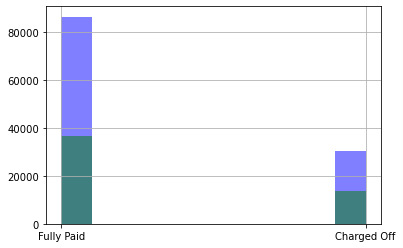

In [42]:
fig, ax = plt.subplots()

data[data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='blue')
data[~data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='green')

<AxesSubplot:>

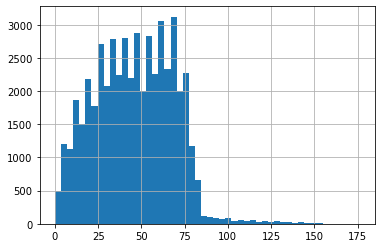

In [39]:
data['mths_since_last_major_derog'].hist(bins = 50)

In [24]:
data['issue_d'].unique()

array(['Dec-15', 'Nov-15', 'Oct-15', 'Sep-15', 'Aug-15', 'Jul-15',
       'Jun-15', 'May-15', 'Apr-15', 'Mar-15', 'Feb-15', 'Jan-15'],
      dtype=object)

In [23]:
data[~data['open_acc_6m'].isna()]['issue_d'].unique()

array(['Dec-15'], dtype=object)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167111 entries, 2 to 421094
Data columns (total 82 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              167111 non-null  int64  
 1   loan_amnt                       167111 non-null  int64  
 2   funded_amnt                     167111 non-null  int64  
 3   term                            167111 non-null  int64  
 4   int_rate                        167111 non-null  float64
 5   installment                     167111 non-null  float64
 6   sub_grade                       167111 non-null  object 
 7   home_ownership                  167111 non-null  object 
 8   annual_inc                      167111 non-null  float64
 9   verification_status             167111 non-null  object 
 10  issue_d                         167111 non-null  object 
 11  loan_status                     167111 non-null  object 
 12  purpose         

In [45]:
drop = ['last_credit_pull_d', 'application_type', 'issue_d', 'id']
data = data.drop(drop, axis=1)

In [46]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [48]:
X.fillna(value=0.0, inplace=True)

In [51]:
y = y.apply(lambda x: 1 if x=='Charged Off' else 0)

In [53]:
dummies = ['sub_grade', 'verification_status', 'purpose','home_ownership']
X = pd.get_dummies(X, columns=dummies, drop_first=True)

In [ ]:
# data['earliest_cr_line'] = data.earliest_cr_line.str.split('-', expand=True)[1]

In [29]:
data = data[X_columns]

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [56]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.9019996397045578
Precision: 0.8921158129175947


In [58]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.9019996397045578
Precision: 0.8921158129175947


In [59]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

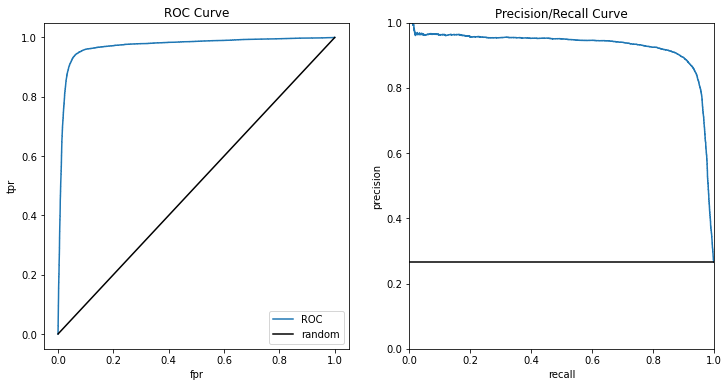

In [60]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(rf_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [61]:
probabilities = rf_model.predict_proba(X_test)[:,1]

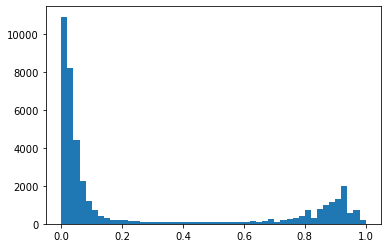

In [62]:
fig, ax = plt.subplots()
ax.hist(probabilities, bins=50);

In [63]:
(probabilities > .5).sum()

11225

In [64]:
y.sum()

44142

In [65]:
threshold = np.linspace(0,1,50)
yhat = rf_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

<ipython-input-65-6ed33272057a>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = c[1][1]/(c[1][1]+c[1][0])


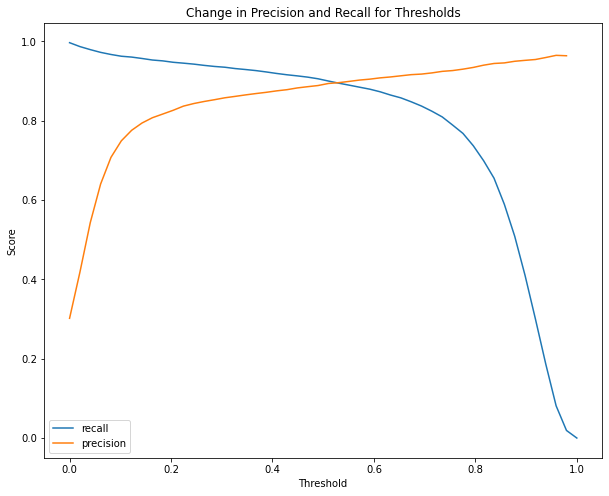

In [66]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167111 entries, 2 to 421094
Data columns (total 79 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              167111 non-null  int64  
 1   loan_amnt                       167111 non-null  int64  
 2   funded_amnt                     167111 non-null  int64  
 3   term                            167111 non-null  int64  
 4   int_rate                        167111 non-null  float64
 5   installment                     167111 non-null  float64
 6   sub_grade                       167111 non-null  object 
 7   home_ownership                  167111 non-null  object 
 8   annual_inc                      167111 non-null  float64
 9   verification_status             167111 non-null  object 
 10  loan_status                     167111 non-null  object 
 11  purpose                         167111 non-null  object 
 12  dti             